# Objective

The objective of the notebook is to build a face detection system that can detect single face from images.

![alt text](https://drive.google.com/uc?export=view&id=13zzmdQBU3W0yyS2DSinQpPE9PRDQeMKI)



# Steps to solve the Face Detection problem

1. Install Dependencies
2. Loading and pre-processing the data
3. Creating annotations as per Detectron2
4. Register the dataset
5. Fine Tuning the model
6. Evaluating model performance

##1. Install Dependencies

In [1]:
# install required version
!pip install pyyaml==5.1

     |████████████████████████████████| 276kB 12.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=40ad35a481b26de1caf343f790c36cfd2e0c978fe7352807b7f915b95fe3e4f5
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# installing detectron2
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 1.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200630-cp36-none-any.whl size=41299 sha256=47084f7da86f771b3c787676d60b00ff843afa6e0aeae52478ffc518f25fcb5e
  Stored in directory: /root/.cache/pip/wheels/80/eb/49/83b9d20a804f1b4b163d1c1451c670a2067a00175662516f01
Successfully built fvcore


##2. Loading and pre-processing the data

In [3]:
# mounting drive
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [5]:
# extracting files
!unzip '/content/drive/My Drive/Wider_dataset/WIDER_train.zip'
!unzip '/content/drive/My Drive/Wider_dataset/WIDER_val.zip'
!unzip '/content/drive/My Drive/Wider_dataset/wider_face_split.zip'

Streaming output truncated to the last 5000 lines.
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_501.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_504.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_507.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_509.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_518.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_529.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_533.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_537.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_spor

In [6]:
# reading files
import pandas as pd

# specify path of the data
path_train = '/content/wider_face_split/wider_face_train_bbx_gt.txt'
path_val = '/content/wider_face_split/wider_face_val_bbx_gt.txt'

# reading data
train = pd.read_csv(path_train,header=None)
val = pd.read_csv(path_val,header=None)

In [7]:
# first 10 rows
train.head(10)

0
0  0--Parade/0_Parade_marchingband_1_849.jpg
1                                          1
2               449 330 122 149 0 0 0 0 0 0 
3        0--Parade/0_Parade_Parade_0_904.jpg
4                                          1
5                361 98 263 339 0 0 0 0 0 0 
6  0--Parade/0_Parade_marchingband_1_799.jpg
7                                         21
8                    78 221 7 8 2 0 0 0 0 0 
9                  78 238 14 17 2 0 0 0 0 0

![alt text](https://drive.google.com/uc?export=view&id=1WN_V0rOz_vLSV6JK-oWHamUxjXUZ-0Wp)

We will reformat the dataframe in the form of image name, num of faces, list of bounding boxes. Lets define the function for the same task

In [8]:
# pre-processing data
# this function accepts the dataframe and returns modified dataframe
def reformat(df):
  
  # fetch values of first column
  values = df[0].values

  # creating empty lists
  names=[]
  num_faces=[]
  bbox=[]

  # fetch values into corresponding lists
  for i in range(len(values)):
      
      # if an image
      if ".jpg" in values[i]:
        
        # no. of faces
        num=int(values[i+1])
        
        # append image name to list
        names.append(values[i])
        
        # append no. of faces to list
        num_faces.append(num)
        
        # create bbox list
        box=[]
        for j in range(i+2,i+2+num):
          box.append(values[j])
        
        # append bbox list to list
        bbox.append(box)
  
  return pd.DataFrame({'name':names,'num_faces':num_faces,'bbox':bbox})

In [9]:
# pre-processing the data 
train = reformat(train)
val = reformat(val)

In [10]:
# first 5 rows of the pre-processed data
train.head()

name  ...                                               bbox
0  0--Parade/0_Parade_marchingband_1_849.jpg  ...                     [449 330 122 149 0 0 0 0 0 0 ]
1        0--Parade/0_Parade_Parade_0_904.jpg  ...                      [361 98 263 339 0 0 0 0 0 0 ]
2  0--Parade/0_Parade_marchingband_1_799.jpg  ...  [78 221 7 8 2 0 0 0 0 0 , 78 238 14 17 2 0 0 0...
3  0--Parade/0_Parade_marchingband_1_117.jpg  ...  [69 359 50 36 1 0 0 0 0 1 , 227 382 56 43 1 0 ...
4  0--Parade/0_Parade_marchingband_1_778.jpg  ...  [27 226 33 36 1 0 0 0 2 0 , 63 95 16 19 2 0 0 ...

[5 rows x 3 columns]

In [11]:
# shape of the training data
train.shape

(12880, 3)

In [12]:
# shape of validation data
val.shape

(3226, 3)

In [13]:
# adding full path
train['name'] = train['name'].apply(lambda x: 'WIDER_train/images/'+x )
val['name']   = val['name'].apply(lambda x: 'WIDER_val/images/'+x )

In [14]:
# first 5 rows
train.head()

name  ...                                               bbox
0  WIDER_train/images/0--Parade/0_Parade_marching...  ...                     [449 330 122 149 0 0 0 0 0 0 ]
1  WIDER_train/images/0--Parade/0_Parade_Parade_0...  ...                      [361 98 263 339 0 0 0 0 0 0 ]
2  WIDER_train/images/0--Parade/0_Parade_marching...  ...  [78 221 7 8 2 0 0 0 0 0 , 78 238 14 17 2 0 0 0...
3  WIDER_train/images/0--Parade/0_Parade_marching...  ...  [69 359 50 36 1 0 0 0 0 1 , 227 382 56 43 1 0 ...
4  WIDER_train/images/0--Parade/0_Parade_marching...  ...  [27 226 33 36 1 0 0 0 2 0 , 63 95 16 19 2 0 0 ...

[5 rows x 3 columns]

In [15]:
# converting bbox to floating point
import numpy as np
train['bbox'] = train['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )
val['bbox']   = val['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )

In [16]:
# first 5 rows
train.head()

name  ...                                               bbox
0  WIDER_train/images/0--Parade/0_Parade_marching...  ...  [[449.0, 330.0, 122.0, 149.0, 0.0, 0.0, 0.0, 0...
1  WIDER_train/images/0--Parade/0_Parade_Parade_0...  ...  [[361.0, 98.0, 263.0, 339.0, 0.0, 0.0, 0.0, 0....
2  WIDER_train/images/0--Parade/0_Parade_marching...  ...  [[78.0, 221.0, 7.0, 8.0, 2.0, 0.0, 0.0, 0.0, 0...
3  WIDER_train/images/0--Parade/0_Parade_marching...  ...  [[69.0, 359.0, 50.0, 36.0, 1.0, 0.0, 0.0, 0.0,...
4  WIDER_train/images/0--Parade/0_Parade_marching...  ...  [[27.0, 226.0, 33.0, 36.0, 1.0, 0.0, 0.0, 0.0,...

[5 rows x 3 columns]

In [17]:
# extracting class names
train['class']= train['name'].apply(lambda x:x.split("/")[2].split("--")[1])
val['class']  = val['name'].apply(lambda x:x.split("/")[2].split("--")[1])

In [18]:
# first 5 rows
train.head()

name  ...   class
0  WIDER_train/images/0--Parade/0_Parade_marching...  ...  Parade
1  WIDER_train/images/0--Parade/0_Parade_Parade_0...  ...  Parade
2  WIDER_train/images/0--Parade/0_Parade_marching...  ...  Parade
3  WIDER_train/images/0--Parade/0_Parade_marching...  ...  Parade
4  WIDER_train/images/0--Parade/0_Parade_marching...  ...  Parade

[5 rows x 4 columns]

In [19]:
# reading class names
easy_df = pd.read_csv('drive/My Drive/Wider_dataset/easy.txt',header=None)
easy_labels = easy_df[0].values

In [20]:
# easy labels
easy_labels

array(['Gymnastics', 'Handshaking', 'Waiter Waitress', 'Press Conference',
       'Worker Laborer', 'Parachutist Paratrooper',
       'Sports Coach Trainer', 'Meeting', 'Aerobics', 'Row Boat',
       'Dancing', 'Swimming', 'Family Group', 'Balloonist', 'Dresses',
       'Couple', 'Jockey', 'Tennis', 'Spa', 'Surgeons'], dtype=object)

In [21]:
# creating empty dataframes
train_df, val_df= pd.DataFrame(), pd.DataFrame()

# fetching rows of easy classes only
for i in easy_labels:
  train_df = pd.concat( [train_df, train[train['class']==i]] )
  val_df   = pd.concat( [val_df, val[val['class']==i]] )

In [22]:
# fetch images of single faces only
train_df= train_df[train_df['num_faces']==1].reset_index(drop=True)
val_df  = val_df[val_df['num_faces']==1].reset_index(drop=True)

In [23]:
# shape of dataframe
train_df.shape, val_df.shape

((1081, 4), (274, 4))

## 3. Creating annotations as per Detectron2

We will see how to convert the annotations of wider dataset to the annotations of Detectron2

In [24]:
# custom annotation format
idx=0
values = train_df.values[idx]
print(values)

['WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_785.jpg' 1
 list([array([480., 212., 102., 120.,   0.,   0.,   0.,   0.,   0.,   0.])])
 'Gymnastics']


![alt text](https://drive.google.com/uc?export=view&id=1AxlMNsub4dt7ARohSlF6mWX7fZmSVmqF)

In [25]:
# for dealing with images
import cv2

# create annotation dict 
record = {}

# image name        
filename = values[0]

# height and width of an image
height, width = cv2.imread(filename).shape[:2]

# creating fields    
record["file_name"] = filename
record["image_id"] = 0
record["height"] = height
record["width"] = width

In [26]:
# different ways to represent bounding box
from detectron2.structures import BoxMode

# create bbox list
objs = []
  
# for every face in an image
for i in range(len(values[2])):
  
  # fetch bbox coordinates
  annos = values[2][i]

  # unpack values
  x1, y1, w, h = annos[0], annos[1], annos[2], annos[3]
  
  # find bottom right corner
  x2, y2 = x1 + w, y1 + h
  
  # create bbox dict
  obj = {       "bbox": [x1, y1, x2, y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0,  
                "iscrowd": 0
        }

  # append bbox dict to bbox list
  objs.append(obj)

In [27]:
# assigning bbox list to annotation dict
record["annotations"] = objs

In [28]:
# standard annotation format
record

{'annotations': [{'bbox': [480.0, 212.0, 582.0, 332.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0}],
 'file_name': 'WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_785.jpg',
 'height': 683,
 'image_id': 0,
 'width': 1024}

In [29]:
def create_annotation(df):  
  
  # create list to store annotation dict
  dataset_dicts = []

  # for each image 
  for idx, v in enumerate(df.values):
    
    # create annotation dict 
    record = {}

    # image name        
    filename = v[0]

    # height and width of an image
    height, width = cv2.imread(filename).shape[:2]

    # assign values to fields    
    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width

    # create list for bbox
    objs = []
    for i in range(len(v[2])):

      # bounding box coordinates
      annos = v[2][i]
      
      # unpack values
      x1, y1, w, h = annos[0], annos[1], annos[2], annos[3]
      
      # find bottom right corner
      x2, y2 = x1 + w, y1 + h
      
      # create bbox dict
      obj = {   "bbox": [x1, y1, x2, y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0,
                "iscrowd": 0
            }

      # append bbox dict to a bbox list      
      objs.append(obj)
    
    # assign bbox list to annotation dict
    record["annotations"] = objs

    # append annotation dict to list
    dataset_dicts.append(record)
  
  return dataset_dicts

In [30]:
# create standard annotations for training and validation datasets
train_annotation = create_annotation(train_df)
val_annotation = create_annotation(val_df)

In [31]:
# standard annotation of an image
train_annotation[0]

{'annotations': [{'bbox': [480.0, 212.0, 582.0, 332.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0}],
 'file_name': 'WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_785.jpg',
 'height': 683,
 'image_id': 0,
 'width': 1024}

##4. Register the dataset

To let detectron2 know how to obtain a dataset, we will implement a function that returns the items in your dataset and then tell detectron2 about this function. For this, we will follow these steps:

1. Register your dataset (i.e., tell detectron2 how to obtain your dataset).

2. Optionally, register metadata for your dataset.

In [32]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# register dataset
DatasetCatalog.register("face_train", lambda d="train": create_annotation(train_df))

In [33]:
# register metadata
MetadataCatalog.get("face_train").set(thing_classes=["face"])

Metadata(name='face_train', thing_classes=['face'])

In [34]:
# for drawing bounding boxes on images
from detectron2.utils.visualizer import Visualizer

# for displaying an image
from google.colab.patches import cv2_imshow

# for randomly selecting images
import random

# get the name of the classes
face_metadata = MetadataCatalog.get("face_train")

print(face_metadata)

Metadata(name='face_train', thing_classes=['face'])


In [35]:
# randomly select images
for d in random.sample(train_annotation, 5):
  
  # read an image
  img = cv2.imread(d["file_name"])

  # create visualizer
  visualizer = Visualizer(img[:, :, ::-1], metadata=face_metadata, scale=0.5)
  
  # draw bounding box on image
  vis = visualizer.draw_dataset_dict(d)
  
  # display an image
  cv2_imshow(vis.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

## 5. Fine Tuning the model

In [36]:
# to obtain pretrained models
from detectron2 import model_zoo

# to train the model
from detectron2.engine import DefaultTrainer

# set up the config
from detectron2.config import get_cfg

# interact with os
import os

# define configure instance
cfg = get_cfg()

# Get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))

# load pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [37]:
# List of the dataset names for training. Must be registered in DatasetCatalog
cfg.DATASETS.TRAIN = ("face_train",)

cfg.DATASETS.TEST = ()

In [38]:
# no. of images per batch
cfg.SOLVER.IMS_PER_BATCH = 2

# set base learning rate
cfg.SOLVER.BASE_LR = 0.001  

# no. of iterations 
cfg.SOLVER.MAX_ITER = 1000

# only has one class (face)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

In [39]:
# create directory to save weights
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# create a trainer with given config
trainer = DefaultTrainer(cfg) 

# If resume==True, and last checkpoint exists, resume from it, load all checkpointables (eg. optimizer and scheduler) and update iteration counter.
# Otherwise, load the model specified by the config (skip all checkpointables) and start from the first iteration.
trainer.resume_or_load(resume=False)

# train the model
trainer.train()

[06/30 14:18:38 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_b796dc.pkl: 152MB [00:15, 10.1MB/s]                           


[06/30 14:19:14 d2.engine.train_loop]: Starting training from iteration 0
[06/30 14:19:25 d2.utils.events]:  eta: 0:08:26  iter: 19  total_loss: 2.102  loss_cls: 1.641  loss_box_reg: 0.431  time: 0.5184  data_time: 0.0390  lr: 0.000020  max_mem: 3915M
[06/30 14:19:36 d2.utils.events]:  eta: 0:08:26  iter: 39  total_loss: 1.562  loss_cls: 1.156  loss_box_reg: 0.431  time: 0.5308  data_time: 0.0069  lr: 0.000040  max_mem: 3915M
[06/30 14:19:46 d2.utils.events]:  eta: 0:08:06  iter: 59  total_loss: 1.099  loss_cls: 0.671  loss_box_reg: 0.412  time: 0.5227  data_time: 0.0054  lr: 0.000060  max_mem: 3915M
[06/30 14:19:57 d2.utils.events]:  eta: 0:08:02  iter: 79  total_loss: 0.802  loss_cls: 0.491  loss_box_reg: 0.316  time: 0.5241  data_time: 0.0061  lr: 0.000080  max_mem: 3915M
[06/30 14:20:07 d2.utils.events]:  eta: 0:07:51  iter: 99  total_loss: 0.679  loss_cls: 0.418  loss_box_reg: 0.287  time: 0.5269  data_time: 0.0051  lr: 0.000100  max_mem: 3915M
[06/30 14:20:18 d2.utils.events]:  e

In [40]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Output hidden; open in https://colab.research.google.com to view.

## 6. Evaluating model performance

In [41]:
# register validation dataset
DatasetCatalog.register("face_val", lambda d="val": create_annotation(val_df))

# register metadata
MetadataCatalog.get("face_val").set(thing_classes=["face"])

Metadata(name='face_val', thing_classes=['face'])

In [42]:
# load the final weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.8

# List of the dataset names for validation. Must be registered in DatasetCatalog
cfg.DATASETS.TEST = ("face_val", )

In [43]:
# set up predictor
from detectron2.engine import DefaultPredictor

# Create a simple end-to-end predictor with the given config that runs on single device for a single input image.
predictor = DefaultPredictor(cfg)

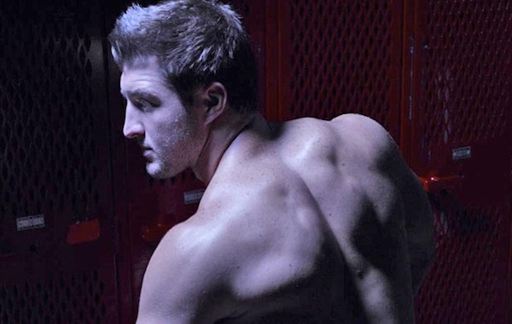

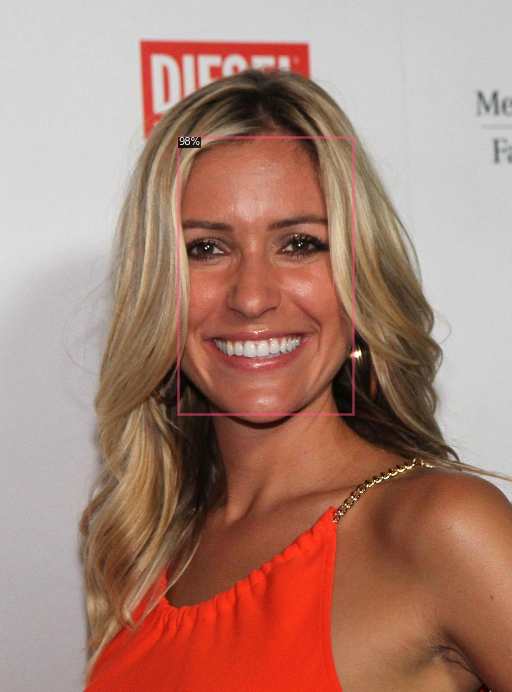

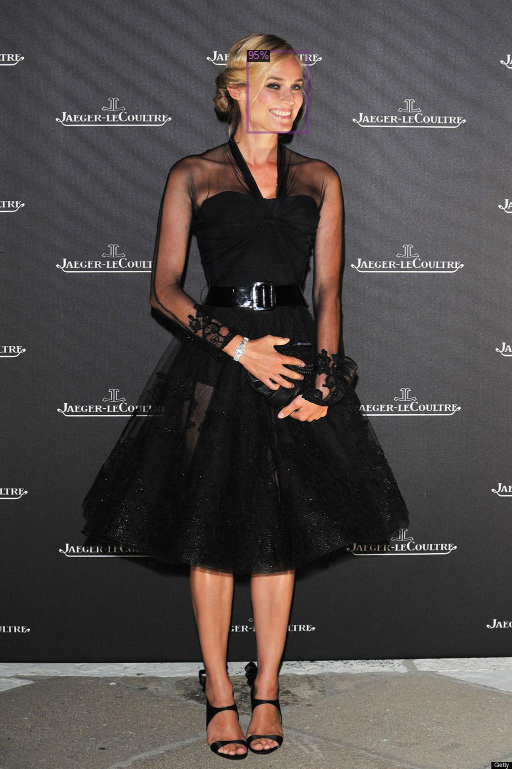

In [44]:
# create standard annotations for validation data
dataset_dicts = create_annotation(val_df)

# randomly select images
for d in random.sample(dataset_dicts,3):    
    
    # read an image
    im = cv2.imread(d["file_name"])
    
    # make predictions
    outputs = predictor(im)
    
    # create visualizer
    v = Visualizer(im[:, :, ::-1], metadata=face_metadata, scale=0.5)
    
    # draw predictions on the image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # display image
    cv2_imshow(v.get_image()[:, :, ::-1])

In [45]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# create a evaluator using COCO metrics
evaluator = COCOEvaluator("face_val", cfg, False, output_dir="./output/")

# create a loader for test data
val_loader = build_detection_test_loader(cfg, "face_val")

# runs the model on each image in the test data and produces the results
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [06/30 14:37:34 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'face_val'. Trying to convert it to COCO format ...
[06/30 14:37:34 d2.data.datasets.coco]: Converting annotations of dataset 'face_val' to COCO format ...)
[06/30 14:37:38 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/30 14:37:38 d2.data.datasets.coco]: Conversion finished, #images: 274, #annotations: 274
[06/30 14:37:38 d2.data.datasets.coco]: Caching COCO format annotations at './output/face_val_coco_format.json' ...
[06/30 14:37:41 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    face    | 274          |
|            |              |
[06/30 14:37:41 d2.data.common]: Serializing 274 elements to byte tensors and concatenating them all ...
[06/30 14:37:41 d2.data.common]: Serialized dataset takes 0.11 MiB
[06/30 14:37:41 d2.evaluation.evaluator]: Start inference on 274 images
[06

OrderedDict([('bbox',
              {'AP': 60.2304465058078,
               'AP50': 93.63357319688033,
               'AP75': 69.07486287882769,
               'APl': 63.90853558351864,
               'APm': 45.51308319576538,
               'APs': 31.07260726072607})])